# 회귀분석 실습 2
## 공공 자전거 수요 예측(Bike Sharing Demand)

###https://www.kaggle.com/c/bike-sharing-demand/overview

 - 데이터 소개
  - 날짜 및 시간, 기온, 습도, 풍속 등의 정보를 정보를 
  
  기반으로 1시간 간격으로 자전거 대여 횟수를 기록한 데이터.
  - 기록 날짜는 2011년 1월 ~ 2012년 12월까지
  - 데이터에 자세한 정보는 소개된 캐글 사이트에서 확인 가능.


### Data Fields
- datetime - hourly date + timestamp
- season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain +  Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals (Dependent Variable)

1. 데이터 불러오기

In [314]:
import calendar
import numpy as np
import pandas as pd
# from pandas.core.frame imort DAtaFrame
# from pandas.core.series import Series 로 불러도 상관없음
import seaborn as sns # 통계적 plot
from scipy import stats # 통계
import missingno as msno # 결측치 보는 plot
from datetime import datetime # day
import matplotlib.pyplot as plt
import warnings # 에러는 아닌데 주의 뜨는 것 방지
warnings.filterwarnings('ignore')

df_train=pd.read_csv('C:/Users/405/my_study/Python_Study/0511/train.csv')
df_test=pd.read_csv('C:/Users/405/my_study/Python_Study/0511/test.csv')


2. 데이터 정보 확인

In [315]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [316]:
df_test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [317]:
print(df_train.shape, df_test.shape)

(10886, 12) (6493, 9)


In [318]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [319]:
df_train.info() # datetime : object type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [320]:
df_train['datetime'] # 0번째 : 2011-01-01[0] 00:00:00[1]

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [321]:
df_train["date"] = df_train.datetime.apply(lambda x : x.split()[0]) # split은 스페이스 중심
df_train["hour"] = df_train.datetime.apply(lambda x : x.split()[1].split(":")[0])
# 날짜와 시간정보를 " " 사이로 쪼개서 새로운 칼럼으로 추가
df_train["weekday"] = df_train.date.apply(lambda dateString : calendar.day_name[
    datetime.strptime(dateString,"%Y-%m-%d").weekday()])
df_train["month"] = df_train.date.apply(lambda dateString : calendar.month_name[
    datetime.strptime(dateString,"%Y-%m-%d").month])
df_train["season"] = df_train.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
df_train["weather"] = df_train.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [322]:
df_train.info() # object으로 뜸 카테고리로 변경

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  object 
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
 12  date        10886 non-null  object 
 13  hour        10886 non-null  object 
 14  weekday     10886 non-null  object 
 15  month       10886 non-null  object 
dtypes: float64(3), int64(6), object(7)
memory usage: 1.3+ MB


In [323]:
categoryVariablesList=['hour','weekday','month', 'season','weather','holiday','workingday']
for var in categoryVariablesList:
    df_train[var]=df_train[var].astype('category')

In [324]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    10886 non-null  object  
 1   season      10886 non-null  category
 2   holiday     10886 non-null  category
 3   workingday  10886 non-null  category
 4   weather     10886 non-null  category
 5   temp        10886 non-null  float64 
 6   atemp       10886 non-null  float64 
 7   humidity    10886 non-null  int64   
 8   windspeed   10886 non-null  float64 
 9   casual      10886 non-null  int64   
 10  registered  10886 non-null  int64   
 11  count       10886 non-null  int64   
 12  date        10886 non-null  object  
 13  hour        10886 non-null  category
 14  weekday     10886 non-null  category
 15  month       10886 non-null  category
dtypes: category(7), float64(3), int64(4), object(2)
memory usage: 842.1+ KB


- 결측치 확인

In [325]:
df_train.isnull().sum()
# df_train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
hour          0
weekday       0
month         0
dtype: int64

<Axes: >

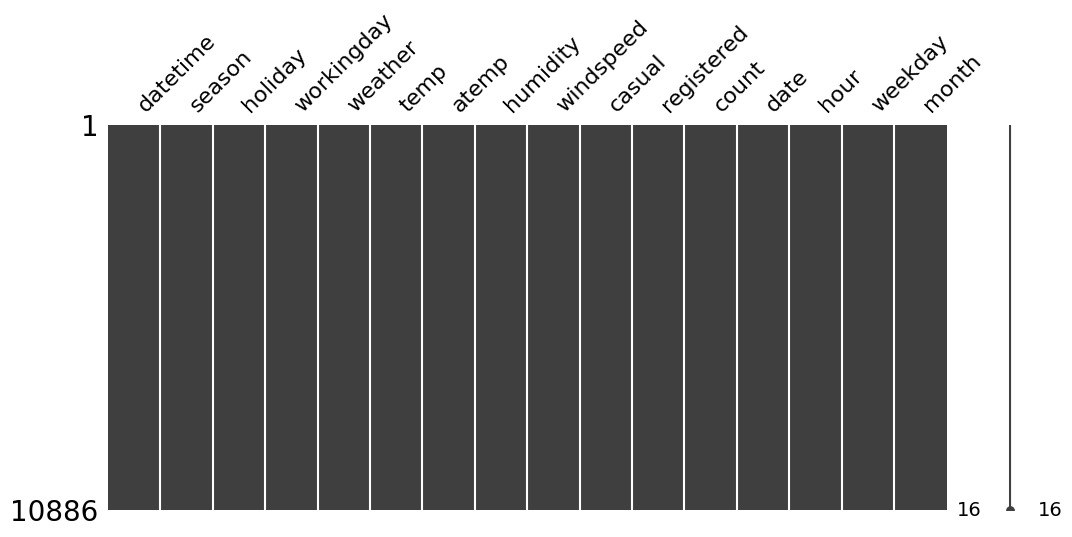

In [326]:
import missingno as msno # 결측치 보는 plot
msno.matrix(df_train, figsize=(12,5))
# 결측치가 있다면 하얀색 줄이 그어짐.

In [327]:
df_train_1=df_train.copy()
df_test_1=df_test.copy() # 훼손 방지하기 위해 카피

df_train_1['datetime']=pd.to_datetime(df_train_1['datetime'],format='%Y-%m-%d %H:%M:%S')

In [328]:
type(df_train_1)

pandas.core.frame.DataFrame

In [329]:
# DataFrame 가능한 것
df_train_1['year']=df_train_1['datetime'].dt.year
df_train_1['month']=df_train_1['datetime'].dt.month
df_train_1['day']=df_train_1['datetime'].dt.day
df_train_1['hour']=df_train_1['datetime'].dt.hour
df_train_1['minute']=df_train_1['datetime'].dt.minute
df_train_1['second']=df_train_1['datetime'].dt.second
# 요일데이터 _ 일요일은 0
df_train_1['dayofweek']=df_train_1['datetime'].dt.dayofweek

[Text(0, 0.5, 'hour'), Text(0.5, 1.0, 'Hour rental amount')]

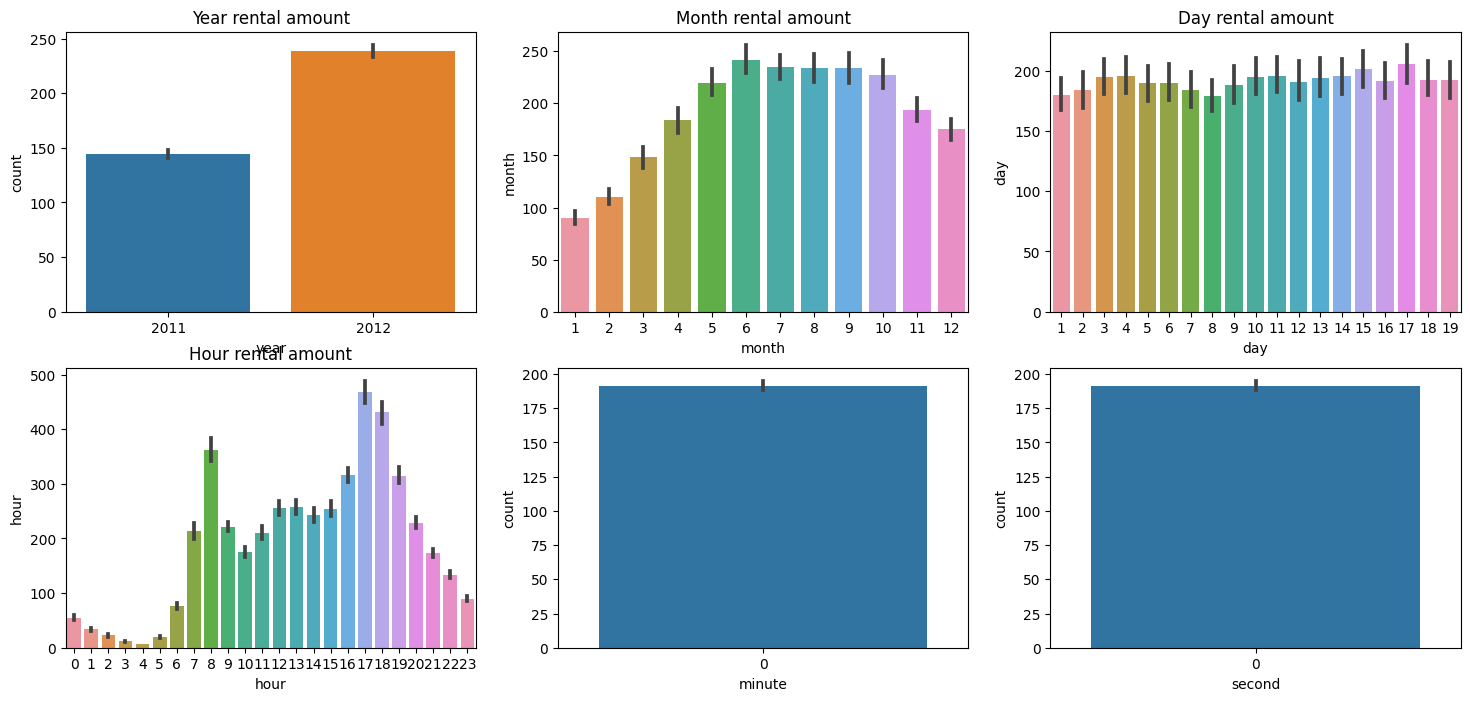

In [330]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(18,8)

sns.barplot(data=df_train_1,x='year',y='count',ax=ax1)
sns.barplot(data=df_train_1,x='month',y='count',ax=ax2)
sns.barplot(data=df_train_1,x='day',y='count',ax=ax3)
sns.barplot(data=df_train_1,x='hour',y='count',ax=ax4)
sns.barplot(data=df_train_1,x='minute',y='count',ax=ax5)
sns.barplot(data=df_train_1,x='second',y='count',ax=ax6)

ax1.set(ylabel='count',title='Year rental amount')
ax2.set(ylabel='month',title='Month rental amount')
ax3.set(ylabel='day',title='Day rental amount')
ax4.set(ylabel='hour',title='Hour rental amount')
# #Day는 분석하면 안됨.-> 달마다 요일이 달라서 카운트 다 다릅니다->지표가 달라짐->분석모델 X

Month rental amount을 보면, 겨울로 분리되는 12월의 경우 초봄인 3~4월의 대여량과 비슷하다는 점이었다.  
워싱턴의 날씨 변화는 우리나라의 사계절과 비슷하다. (여기서 알수 있는 점은 계절의 영향은 별로 없음)  
  
또한 hour 파트에서 아침7시와 저녁 6~7시의 수요량이 다른 시간대들과 비교했을 때 굉장히 높은 것을 알 수 있다.  
이는 출퇴근길에 자전거를 많이 이용하는 사람들이 많다고 예측해 볼 수 있다. (주말과 나눠서 보는 것이 필요하다.)  
  
혹시라도 뭐가 다를지 모르겠어서 일별 대여량은 1일부터 19일까지만 있고 나머지 날짜의 경우는 test데이터에 들어가있다.  
따라서 이 변수는 피쳐로 사용하면 안 된다!  

### Quantile, Quartile, Percentile 개념 정리

- 참고 : https://blog.eunsukim.me/posts/understanding-quantile-quartile-and-percentile

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Working or nor rental amount')]

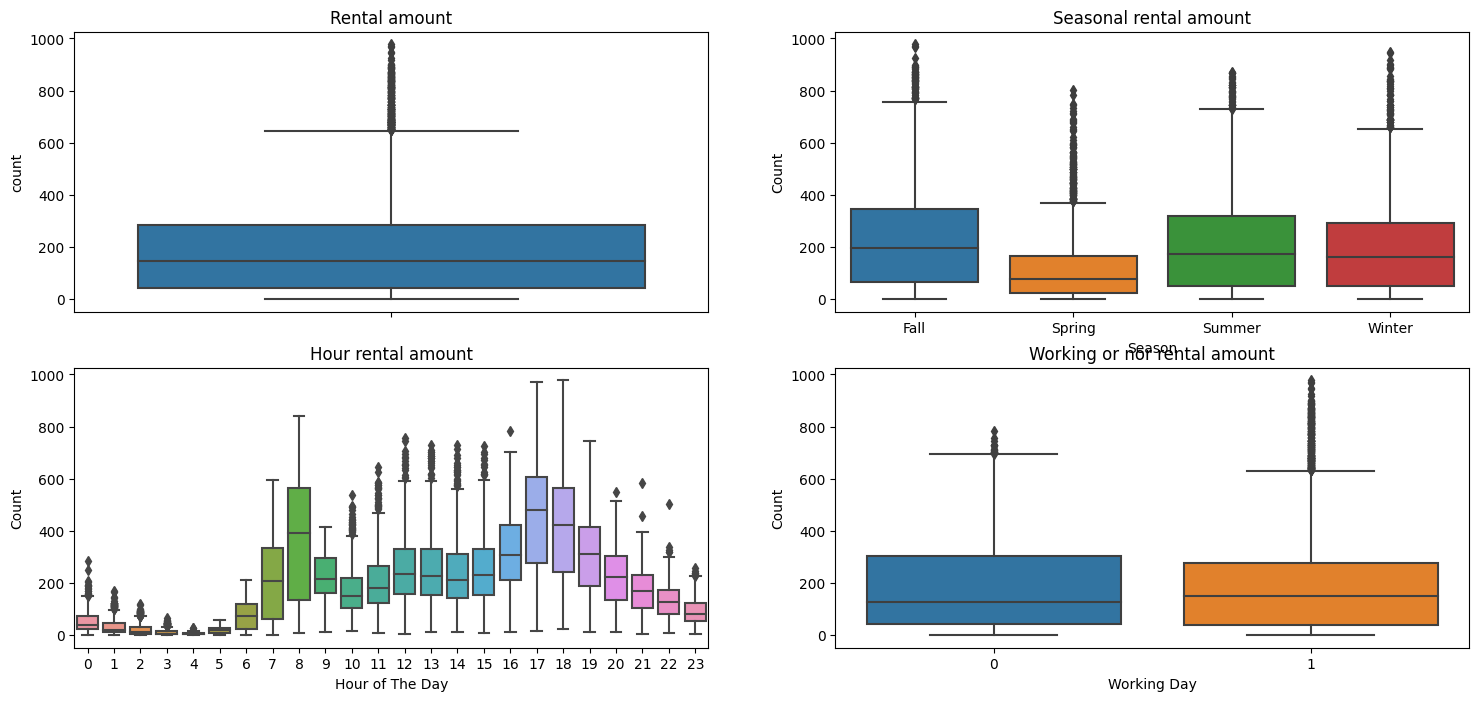

In [331]:
fig,axes=plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(18,8)

sns.boxplot(data=df_train_1,y='count',orient='v', ax=axes[0][0])
sns.boxplot(data=df_train_1,y='count',x='season', orient='v', ax=axes[0][1])
sns.boxplot(data=df_train_1,y='count',x='hour', orient='v', ax=axes[1][0])
sns.boxplot(data=df_train_1,y='count',x='workingday', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='count',title='Rental amount')
axes[0][1].set(xlabel='Season',ylabel='Count', title='Seasonal rental amount')
axes[1][0].set(xlabel='Hour of The Day',ylabel='Count', title='Hour rental amount')
axes[1][1].set(xlabel='Working Day',ylabel='Count', title='Working or nor rental amount')
# 이상치가 많음, 이상치 처리가 필요

<Axes: xlabel='hour', ylabel='count'>

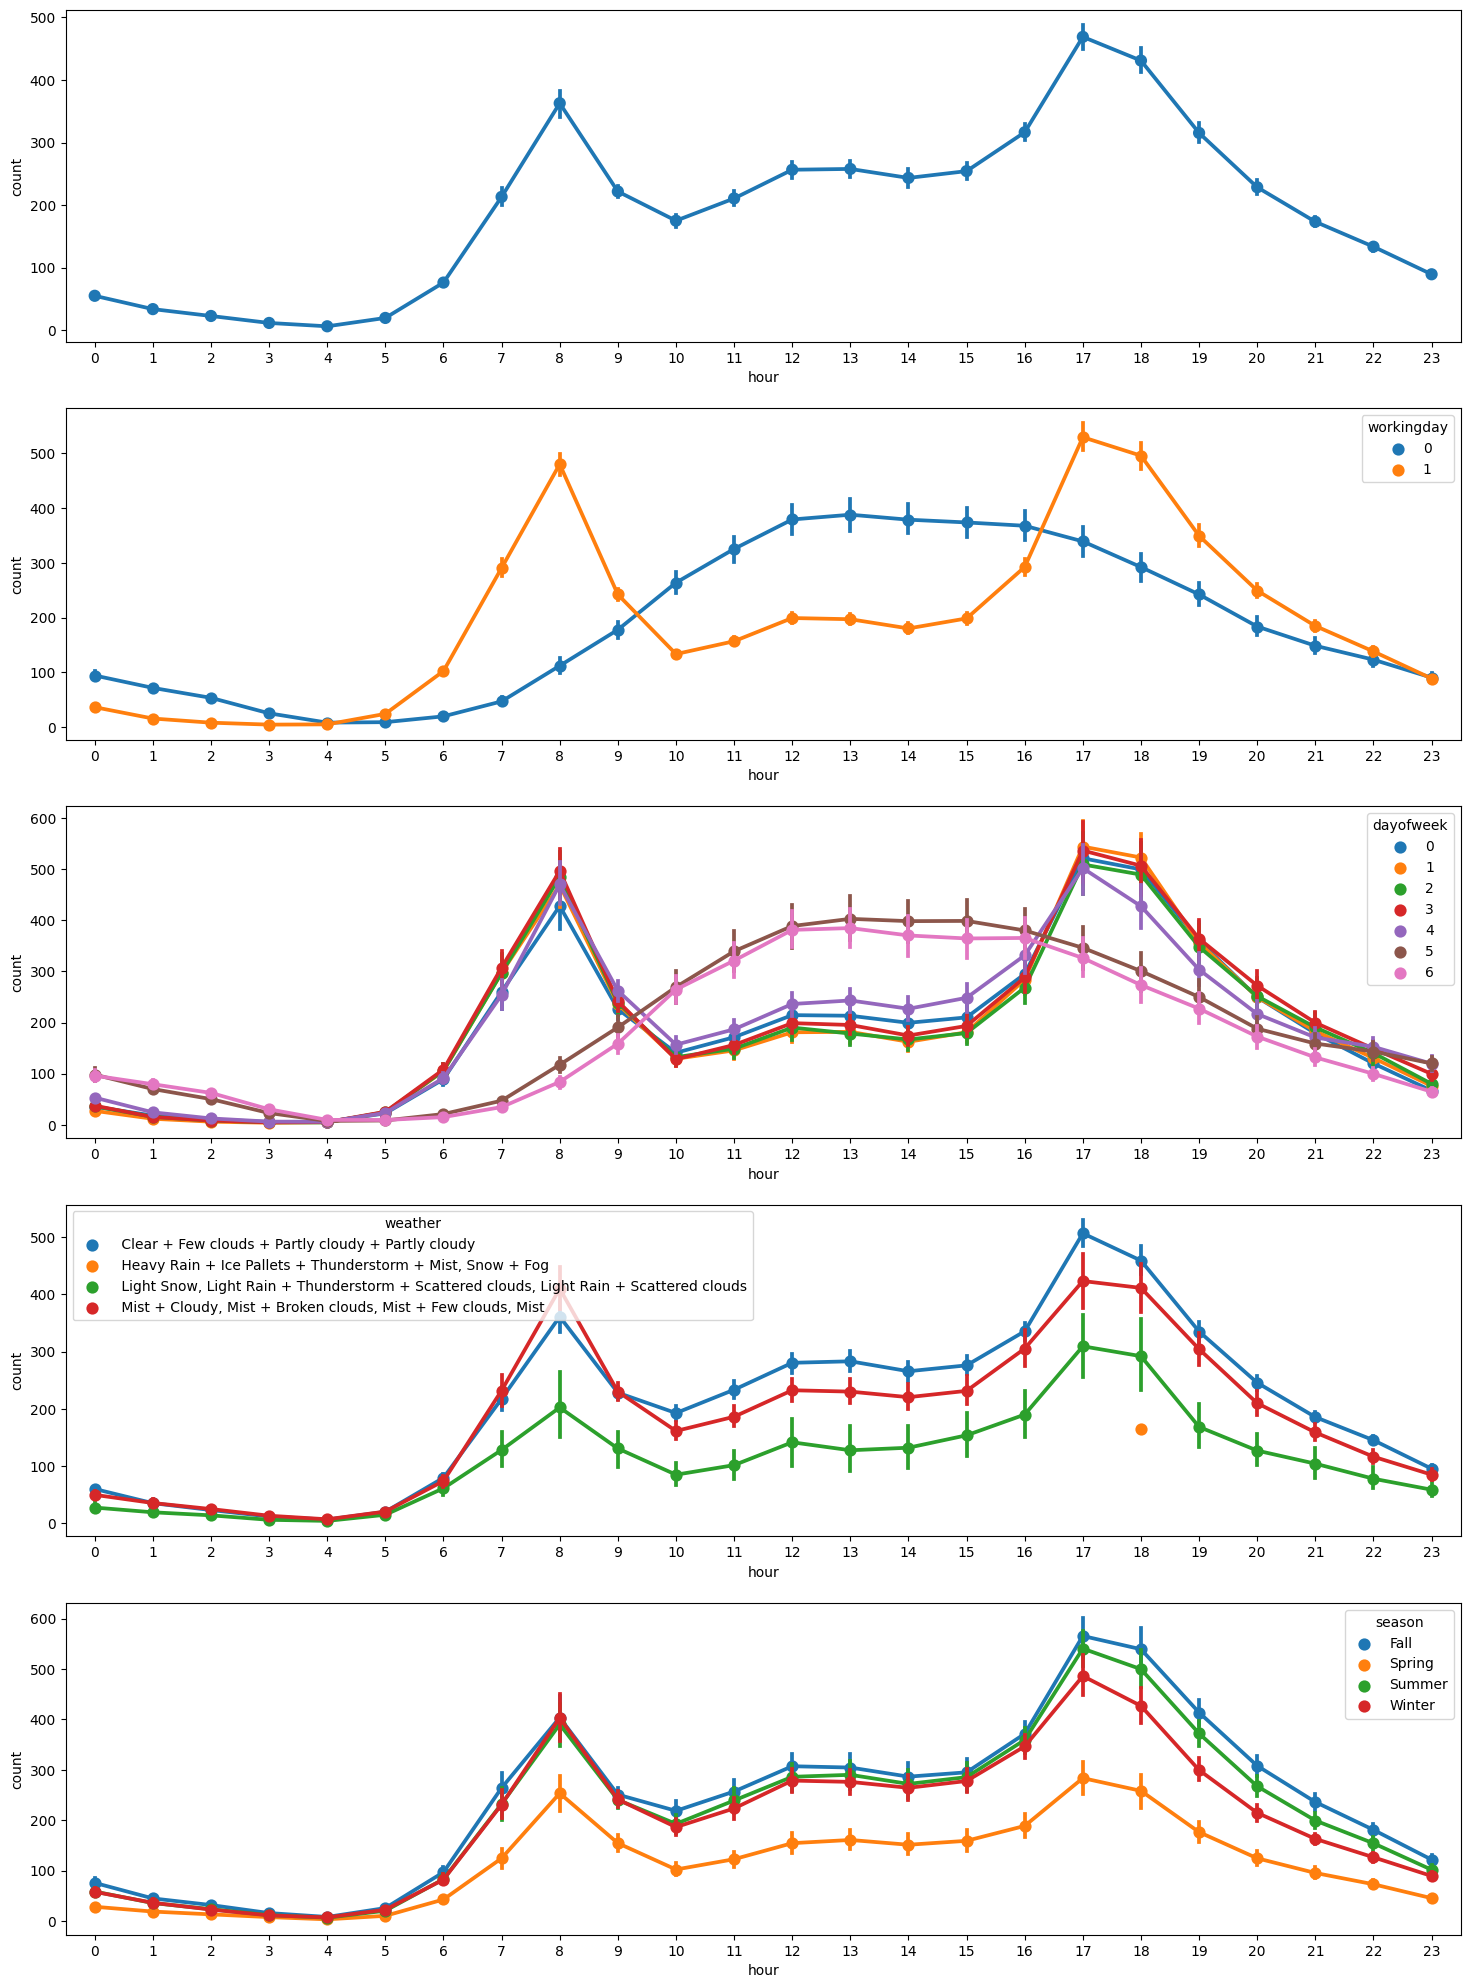

In [332]:
fig, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(nrows=5)
fig.set_size_inches(18,25)

# 꺾은선그래프
sns.pointplot(data=df_train_1, x='hour', y='count', ax=ax1)
sns.pointplot(data=df_train_1, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=df_train_1, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=df_train_1, x='hour', y='count', hue='weather', ax=ax4)
sns.pointplot(data=df_train_1, x='hour', y='count', hue='season', ax=ax5)

위 그래프를 보면 대여량은 특정 기간에 머물러 있고 특히 근무일이 아닐 때 대여량이 더 많은 것을 알 수 있다.

- 상관관계

In [333]:
df_train_2 = df_train_1[['temp','atemp','casual','registered','humidity','windspeed','count']]
corrMatt = df_train_2.corr()
print(corrMatt)
mask = np.array(corrMatt)
#Return the indices for the upper-triangle of arr.
#상삼각행렬
mask[np.tril_indices_from(mask)] = False #상삼각행렬 False -> 하삼각행렬

                temp     atemp    casual  registered  humidity  windspeed   
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852  \
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<Axes: >

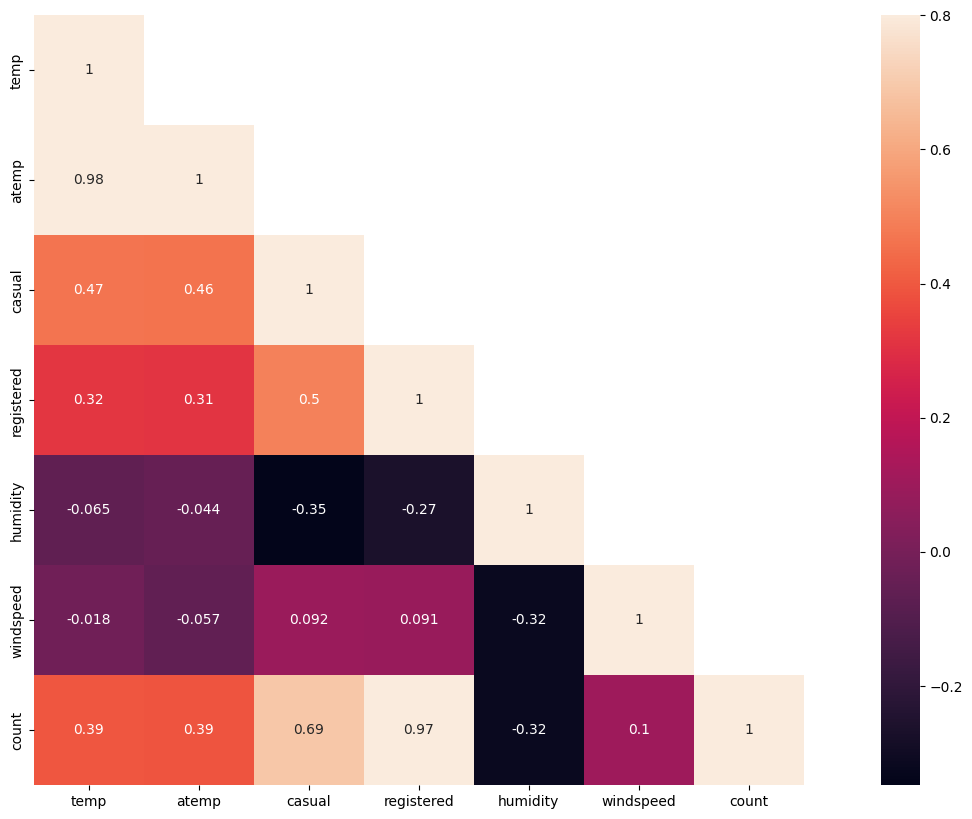

In [334]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

1. temp, humidity, windspeed는 상관관계가 거의 없다.
2. registered, casual는 상관관계가 높다!
3. atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피쳐로 사용하기에 적합하지 않을 수 있다.

### regplot으로 산점도 plot을 그림

<Axes: xlabel='humidity', ylabel='count'>

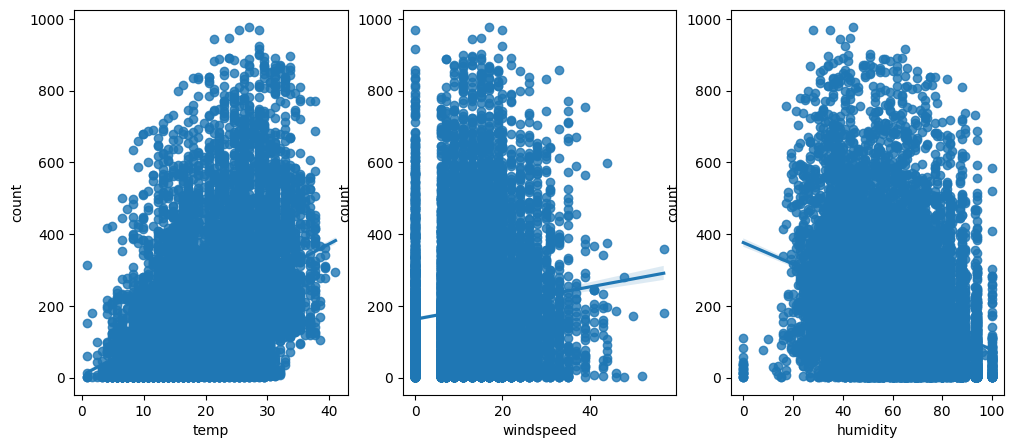

In [335]:
fig, (ax1,ax2,ax3)=plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x='temp',y='count',data=df_train_1,ax=ax1)
sns.regplot(x='windspeed',y='count',data=df_train_1, ax=ax2)
sns.regplot(x='humidity',y='count', data=df_train_1,ax=ax3)
#temp,winspeed, humidity -> 회귀로 절대로 못맞침
#(상관계수가 낮음->scatter->drop하는것이 좋지 않을까?)->항상 좋을까?->실험적이여야 함.

windspeed의 경우 0에 숫자가 몰려 있는 것으로 보아, 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측

In [336]:
# 월별 데이터 모아보기
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year,datetime.month)
df_train_1['year_month']=df_train_1['datetime'].apply(concatenate_year_month)
print(df_train_1.shape)
df_train_1[["datetime",'year_month']].head()

(10886, 22)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<Axes: xlabel='year_month', ylabel='count'>

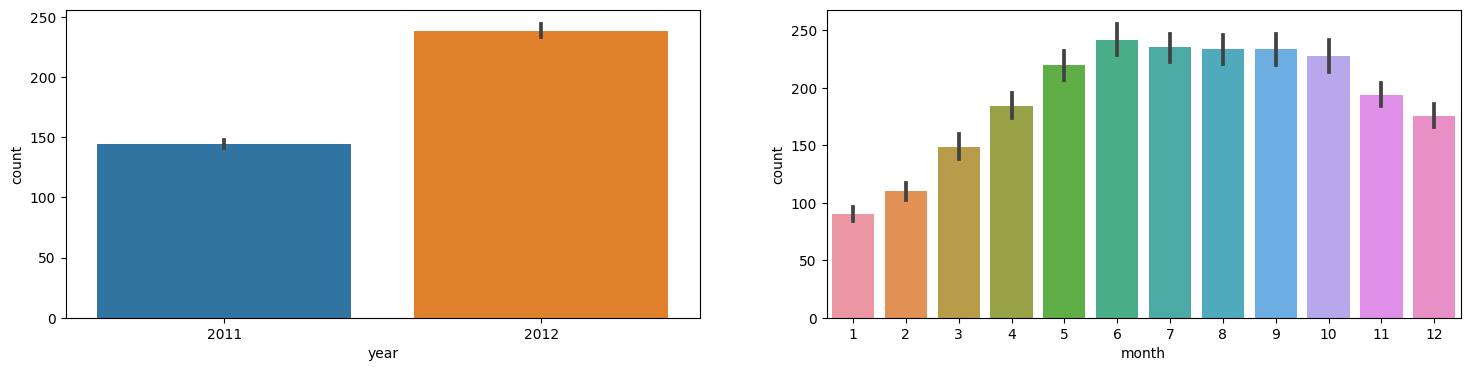

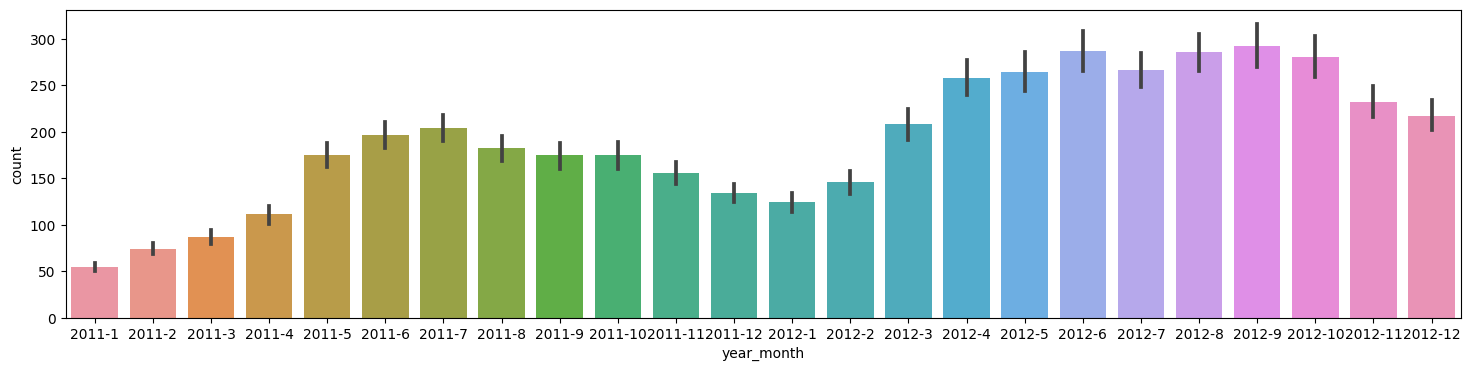

In [337]:
fig, (ax1,ax2)=plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=df_train_1, x='year',y='count',ax=ax1)
sns.barplot(data=df_train_1, x='month',y='count',ax=ax2)

fig,ax3=plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=df_train_1,x='year_month',y='count',ax=ax3)

- 분석 결과 : 2011년보다 2012년에 대여량이 더 많다. ->달로 나눠도 증가하고 있습니다.

### 이상치 처리

#### 방법1) IQR(Interquartile Range)  = Q3(75%)-Q1(25%)

$Q1-1.5*IQR ~:~$ 최소 제한선


$Q3 + 1.5*IQR ~:~$   최대 제한선



범위를 좀 더 조정

In [338]:
#'count' 데이터에서 전체의 25%에 해당하는 데이터 조회
count_q1=np.percentile(df_train_1['count'],25)
count_q1

#'count' 데이터에서 전체의 75%에 해당하는 데이터 조회
count_q3=np.percentile(df_train_1['count'],75)
count_q3

# IQR =Q3=Q1
count_IQR=count_q3-count_q1
count_IQR

# 이상치를 제외한(이상치가 아닌 구간에 있는) 데이터만 조회
df_train_1_IQR=df_train_1[(df_train_1['count']>=(count_q1-(1.5*count_IQR)))& 
                        (df_train_1['count']<=(count_q3+(1.5*count_IQR)))]
print(df_train_1_IQR)

                 datetime  season holiday workingday   
0     2011-01-01 00:00:00  Spring       0          0  \
1     2011-01-01 01:00:00  Spring       0          0   
2     2011-01-01 02:00:00  Spring       0          0   
3     2011-01-01 03:00:00  Spring       0          0   
4     2011-01-01 04:00:00  Spring       0          0   
...                   ...     ...     ...        ...   
10881 2012-12-19 19:00:00  Winter       0          1   
10882 2012-12-19 20:00:00  Winter       0          1   
10883 2012-12-19 21:00:00  Winter       0          1   
10884 2012-12-19 22:00:00  Winter       0          1   
10885 2012-12-19 23:00:00  Winter       0          1   

                                                 weather   temp   atemp   
0       Clear + Few clouds + Partly cloudy + Partly c...   9.84  14.395  \
1       Clear + Few clouds + Partly cloudy + Partly c...   9.02  13.635   
2       Clear + Few clouds + Partly cloudy + Partly c...   9.02  13.635   
3       Clear + Few clouds 

#### 방법2) 3-sigma, 평균 $\pm$ 3* 표준편차차

In [339]:
df_train_1_sigma=df_train_1[np.abs(df_train_1['count']-df_train_1['count'].mean())<
                            (3*df_train_1['count'].std())]
print(df_train_1_sigma)
#약 100개 정도 잃어버림 

                 datetime  season holiday workingday   
0     2011-01-01 00:00:00  Spring       0          0  \
1     2011-01-01 01:00:00  Spring       0          0   
2     2011-01-01 02:00:00  Spring       0          0   
3     2011-01-01 03:00:00  Spring       0          0   
4     2011-01-01 04:00:00  Spring       0          0   
...                   ...     ...     ...        ...   
10881 2012-12-19 19:00:00  Winter       0          1   
10882 2012-12-19 20:00:00  Winter       0          1   
10883 2012-12-19 21:00:00  Winter       0          1   
10884 2012-12-19 22:00:00  Winter       0          1   
10885 2012-12-19 23:00:00  Winter       0          1   

                                                 weather   temp   atemp   
0       Clear + Few clouds + Partly cloudy + Partly c...   9.84  14.395  \
1       Clear + Few clouds + Partly cloudy + Partly c...   9.02  13.635   
2       Clear + Few clouds + Partly cloudy + Partly c...   9.02  13.635   
3       Clear + Few clouds 

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Working or nor rental amount')]

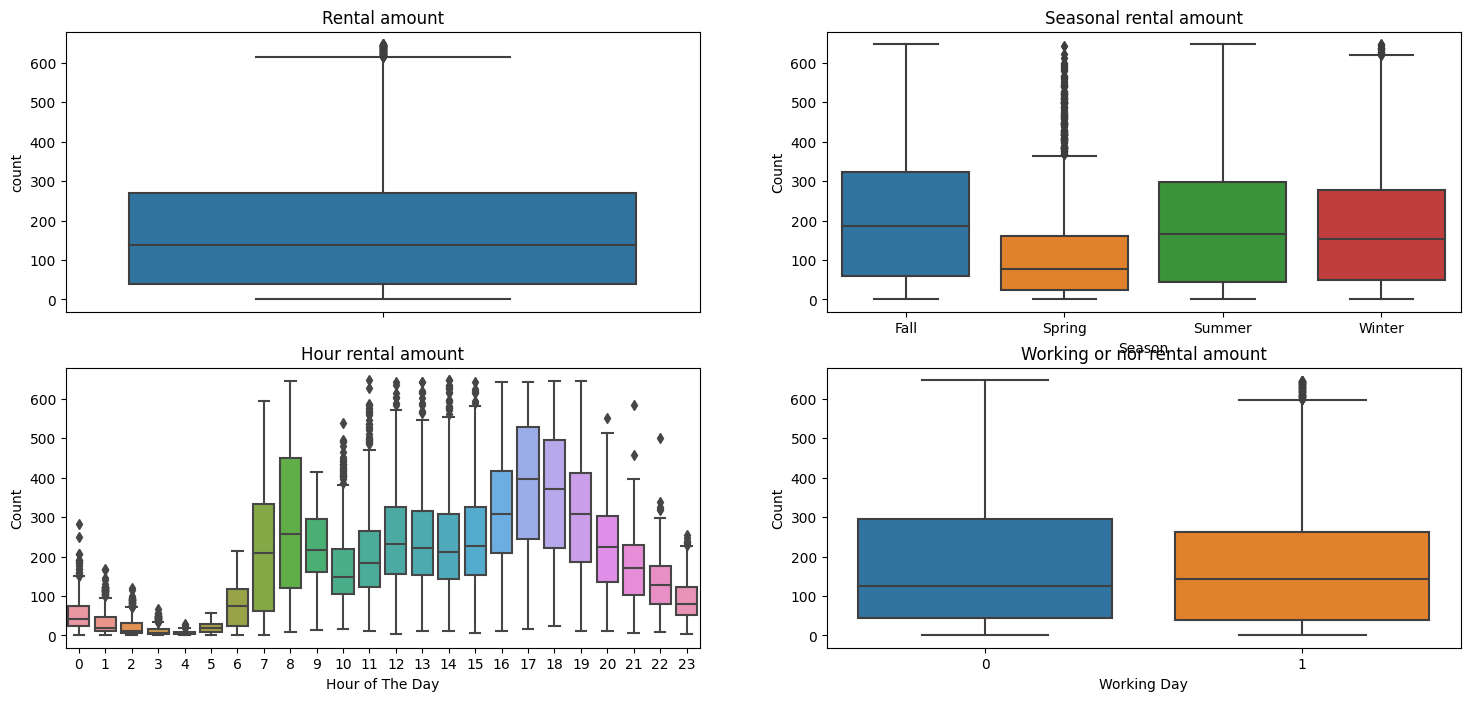

In [340]:
fig,axes=plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(18,8)

sns.boxplot(data=df_train_1_IQR,y='count',orient='v', ax=axes[0][0])
sns.boxplot(data=df_train_1_IQR,y='count',x='season', orient='v', ax=axes[0][1])
sns.boxplot(data=df_train_1_IQR,y='count',x='hour', orient='v', ax=axes[1][0])
sns.boxplot(data=df_train_1_IQR,y='count',x='workingday', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='count',title='Rental amount')
axes[0][1].set(xlabel='Season',ylabel='Count', title='Seasonal rental amount')
axes[1][0].set(xlabel='Hour of The Day',ylabel='Count', title='Hour rental amount')
axes[1][1].set(xlabel='Working Day',ylabel='Count', title='Working or nor rental amount')
# 이상치가 많음, 이상치 처리가 필요

- 3-sigma를 적용했을때

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Working or nor rental amount')]

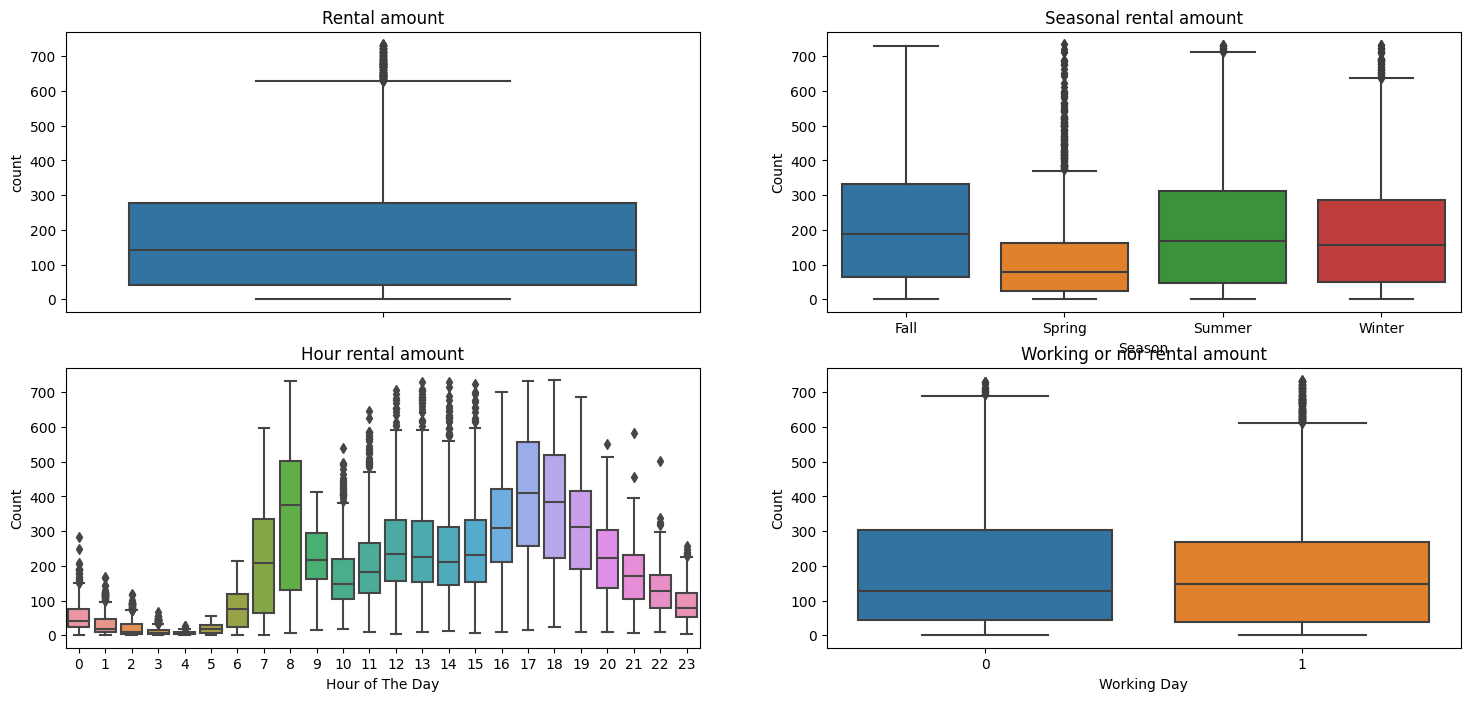

In [341]:
fig,axes=plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(18,8)

sns.boxplot(data=df_train_1_sigma,y='count',orient='v', ax=axes[0][0])
sns.boxplot(data=df_train_1_sigma,y='count',x='season', orient='v', ax=axes[0][1])
sns.boxplot(data=df_train_1_sigma,y='count',x='hour', orient='v', ax=axes[1][0])
sns.boxplot(data=df_train_1_sigma,y='count',x='workingday', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='count',title='Rental amount')
axes[0][1].set(xlabel='Season',ylabel='Count', title='Seasonal rental amount')
axes[1][0].set(xlabel='Hour of The Day',ylabel='Count', title='Hour rental amount')
axes[1][1].set(xlabel='Working Day',ylabel='Count', title='Working or nor rental amount')
# 이상치가 많음, 이상치 처리가 필요

- 모델적용

In [342]:
dataTrain=pd.read_csv("C:/Users/405/my_study/Python_Study/0511/train.csv")
dataTest=pd.read_csv("C:/Users/405/my_study/Python_Study/0511/test.csv")

In [343]:
data=pd.concat([dataTrain,dataTest])
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [344]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


- Feature Engineering

In [345]:
data['date'] = data.datetime.apply(lambda x:x.split()[0])
data['hour'] = data.datetime.apply(lambda x:x.split()[1].split(':')[0]).astype('int')
data['year'] = data.datetime.apply(lambda x:x.split()[0].split('-')[0])
data['weekday'] = data.date.apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').weekday())
data['month'] = data.date.apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d' ).month)

- 데이터 변환

In [346]:
categoricalFeatureNames=['season','holiday','workingday','weather','weekday','month','year','hour']
numericalFeatureName = ['temp','humidity','windspeed','atemp']
dropFeatures = ['casual','count','datetime','date','registered']

In [347]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype('category')

- Splitting Train and Test Data

In [348]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=['datetime'])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=['datetime'])
datetimecol = dataTest['datetime']
yLabels = dataTrain['count']
yLabelsRegistered = dataTrain['registered']
yLabelsCasual = dataTrain['casual']

In [349]:
dataTrain

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,2011-01-01,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,2011-01-01,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,2011-01-01,2,2011,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,2011-01-01,3,2011,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,2011-01-01,4,2011,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7.0,329.0,336.0,2012-12-19,19,2012,2,12
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10.0,231.0,241.0,2012-12-19,20,2012,2,12
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4.0,164.0,168.0,2012-12-19,21,2012,2,12
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12.0,117.0,129.0,2012-12-19,22,2012,2,12


- Dropping Unncessary Variables

In [350]:
dataTrain = dataTrain.drop(dropFeatures,axis=1)
dataTest = dataTest.drop(dropFeatures,axis=1)

RMSLE Scorer

In [351]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

#np.nan_to_num : Replace NaN with zero and infinity with large finite numbers (default behaviour) 
#or with the numbers defined by the user using the nan, posinf and/or neginf keywords.

In [352]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y-log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
#sklearn의 mean_squared_error 이용해 RMSE계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))


#MSE, RMSE, RMSLE 계산
def evaluate_rgre(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE:{0:.3f}, RMSE:{1:.3f}, MAE:{2:.3f}'.format(rmsle_val,rmse_val,mae_val))

- Numeri으로 변환

In [353]:
#분리를 통해 추출된 속성은 문자열 속성을 가지고 있음 따라서 숫자형 데이터로 변환해 줄 필요가 있음.
#pandas.to_numeric(): https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_numeric.html
#errors='coerce' : 만약 숫자로 변경할 수 없는 데이터라면 기존 데이터를 지우고 NaN으로 설정하여 반환.
dataTrain['year'] = pd.to_numeric(dataTrain.year,errors='coerce')
dataTrain['month'] = pd.to_numeric(dataTrain.month,errors='coerce')
dataTrain['hour'] = pd.to_numeric(dataTrain.hour,errors='coerce')
dataTrain['weekday'] = pd.to_numeric(dataTrain.weekday,errors='coerce')

dataTrain['season'] = pd.to_numeric(dataTrain.season,errors='coerce')
dataTrain['holiday'] = pd.to_numeric(dataTrain.holiday,errors='coerce')
dataTrain['workingday'] = pd.to_numeric(dataTrain.workingday,errors='coerce')
dataTrain['weather'] = pd.to_numeric(dataTrain.weather,errors='coerce')

- Linear Regression Model

In [354]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels) # log1p=log(1+x) # log1=0
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds)))

RMSLE Value For Linear Regression:  0.9778188829547183


- Regularization Model-Ridge

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression: 0.9778188678218593
CPU times: total: 531 ms
Wall time: 561 ms


<Axes: xlabel='param_alpha', ylabel='rmsle'>

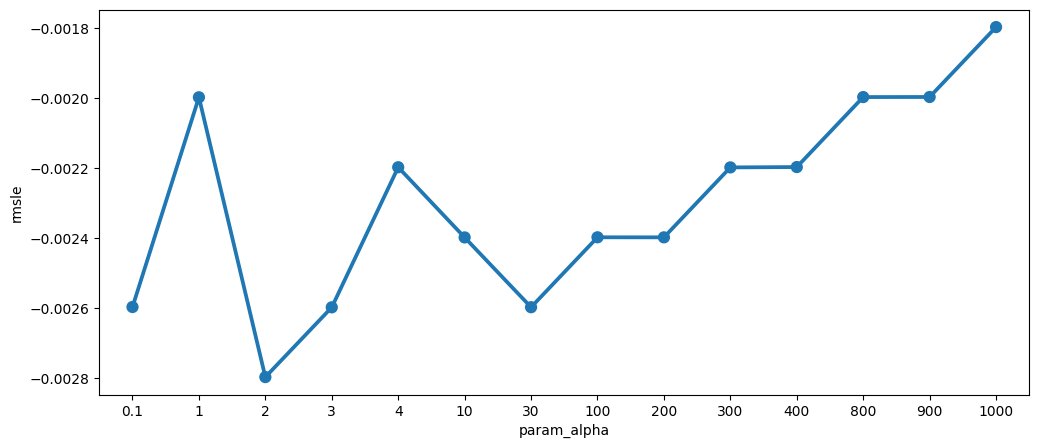

In [357]:
%%time
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog=np.log1p(yLabels)
grid_ridge_m.fit(dataTrain,yLabelsLog)
preds=grid_ridge_m.predict(X=dataTrain)
print(grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression:", rmsle(np.exp(yLabelsLog),np.exp(preds)))
fig,ax=plt.subplots()
fig.set_size_inches(12,5)
df=pd.DataFrame(grid_ridge_m.cv_results_)
df["rmsle"]=df["mean_score_time"].apply(lambda x:-x)
sns.pointplot(data=df,x=df['param_alpha'],y="rmsle",ax=ax)

- 선형회귀가정

## Logistic Regression


## Logistic function

$g(x) = {\dfrac {e^x}{1+e^x}}$

다른 말로 시그모이드(Sigmoid)함수라고 함. 그 모양이 S자와 유사한 성질이 있음.

독립변수의 선형결학을 이용하여 사건의 발생 가능성을 예측하는데 사용되는 통계기법.

앞에서 선형회귀에서 우리는 1차 선형함수를 배웠다.

$y = Wx+b$

$y = W_1X_1+W_2X_2 +\cdots + W_nX_n +b$

오즈비

${\dfrac{p}{1-p}}$

$ln{\dfrac{p}{1-p}} = WX$

${\dfrac{p}{1-p}} = e^{WX}$

양변에 역수를 취하면,

${\dfrac{1-p}{p}} = {\dfrac{1}{p}}-1 = {\dfrac{1}{e^{WX}}}$

${\dfrac{1}{p}} = {\dfrac{1}{e^{WX}}} +1 = {\dfrac
{1}{e^{WX}}}+{\dfrac{e^{WX}}{e^{WX}}} = {\dfrac{1+e^{WX}}{e^{WX}}}$

다시 한번 역수를 취하면

$p = {\dfrac {e^{WX}}{1+e^{{WX}}}}$

우리가 아는 식으로 변형하면

$p = {\dfrac{e^{WX}}{1+e^{WX}}} \cdot {\dfrac{{\dfrac {1}{e^{WX}}}}{{\dfrac{1}{e^{WX}}}}} = {\dfrac{1}{\dfrac{1}{e^{WX}}+1}} = {\dfrac {1}{e^{-WX}}}$ 

위스콘신 유방암 예측

- 총 309개의 속성과 malignant(악성), benign(양성)의 타겟값을 가지고 있다

**데이터셋 조회**

빌트인 데이터셋은 sklearn.utils.Bunch 라는 자료구조를 활용합니다.

key-value 형식으로 구성되어 있으며, 사전(dict)형 타입과 유사한 구조를 가지고 있습니다.

공통 key는 다음과 같습니다.

- data: 샘플 데이터, Numpy 배열로 이루어져 있습니다.
- target: Label 데이터, Numpy 배열로 이루어져 있습니다.
- feature_names: Feature 데이터의 이름
- target_names: Label 데이터의 이름
- DESCR: 데이터 셋의 설명
- filename: 데이터 셋의 파일 저장 위치 (csv)

In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer=load_breast_cancer()

In [402]:
type(cancer)

sklearn.utils.Bunch

In [403]:
dir(cancer)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [404]:
cancer.data.shape

(569, 30)

In [405]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [406]:
cancer.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [407]:
np.bincount(cancer.target) # 빈도수

array([212, 357], dtype=int64)

In [408]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [409]:
for i, name in enumerate(cancer.feature_names): # 이름에 순번을 달아놓음
    print('%02d:%s'%(i,name))

00:mean radius
01:mean texture
02:mean perimeter
03:mean area
04:mean smoothness
05:mean compactness
06:mean concavity
07:mean concave points
08:mean symmetry
09:mean fractal dimension
10:radius error
11:texture error
12:perimeter error
13:area error
14:smoothness error
15:compactness error
16:concavity error
17:concave points error
18:symmetry error
19:fractal dimension error
20:worst radius
21:worst texture
22:worst perimeter
23:worst area
24:worst smoothness
25:worst compactness
26:worst concavity
27:worst concave points
28:worst symmetry
29:worst fractal dimension


In [410]:
print('data=>',cancer.data.shape)
print('target=>',cancer.target.shape)

malignant=cancer.data[cancer.target==0]
benign=cancer.data[cancer.target==1]

print('malignant(악성) =>', malignant.shape)
print('benign(악성) =>', benign.shape)

data=> (569, 30)
target=> (569,)
malignant(악성) => (212, 30)
benign(악성) => (357, 30)


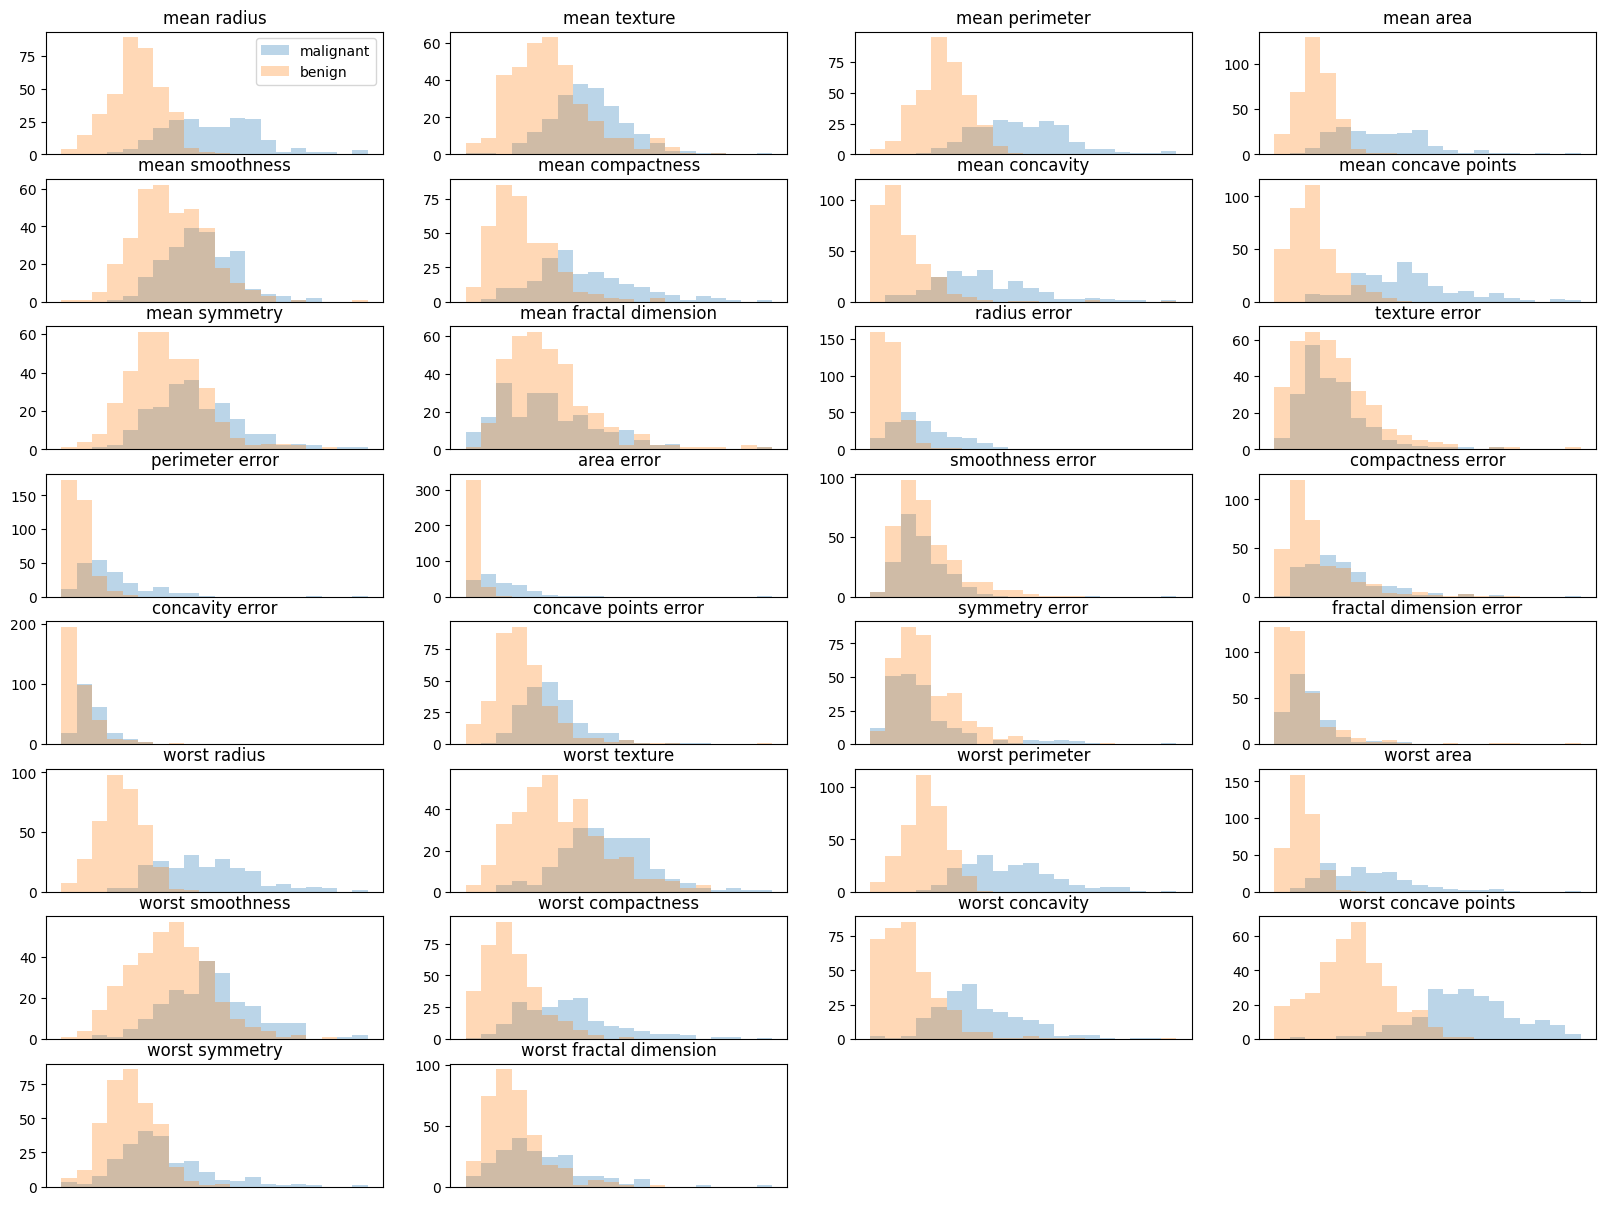

In [411]:
plt.figure(figsize=[20,15])

for col in range(len(cancer.feature_names)):
    plt.subplot(8,4,col+1)
    _,bins=np.histogram(cancer.data[:,col],bins=20)

    plt.hist(malignant[:,col],bins=bins,alpha=0.3)
    plt.hist(benign[:,col], bins=bins,alpha=0.3)
    plt.title(cancer.feature_names[col])
    if col==0:plt.legend(cancer.target_names)
    plt.xticks([])

In [412]:
from sklearn.linear_model import LogisticRegression

scores=[]

for i in range(10): # for문이 교차검증과 비슷한 기능
    X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,
                                                   test_size=0.2)
    model=LogisticRegression(max_iter=5000)
    model.fit(X_train,y_train)

    score=model.score(X_test,y_test)
    scores.append(score)

print('scores=', scores)

scores= [0.9035087719298246, 0.9210526315789473, 0.9385964912280702, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.956140350877193, 0.9210526315789473, 0.9473684210526315, 0.9649122807017544]


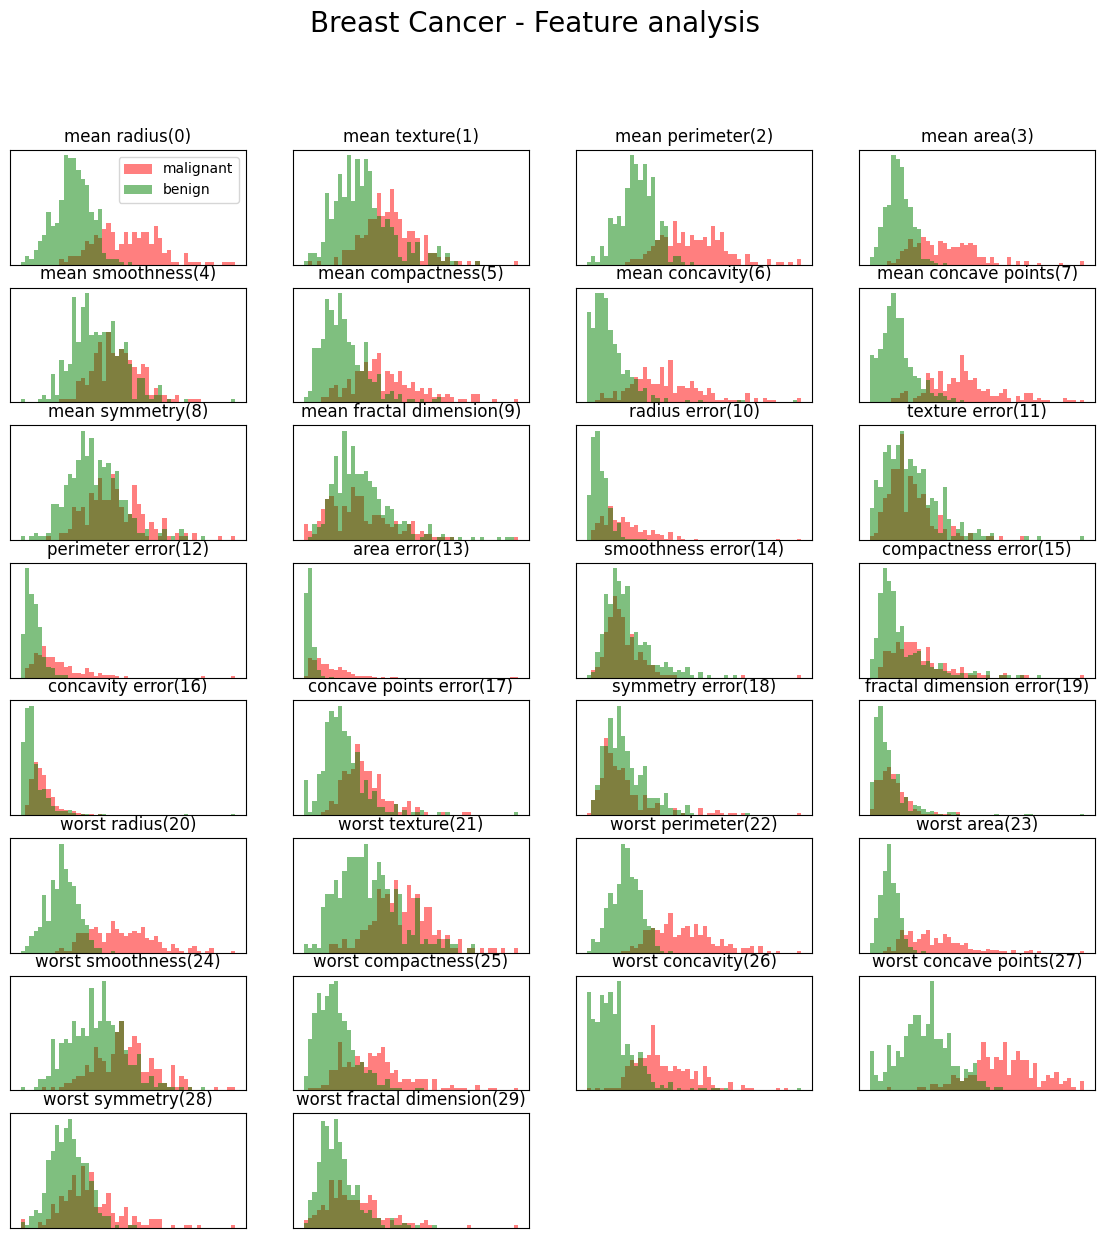

In [417]:
fig=plt.figure(figsize=[14,14])
fig.suptitle('Breast Cancer - Feature analysis', fontsize=20)

for col in range(len(cancer.feature_names)):
    plt.subplot(8,4,col+1)
    _,bins=np.histogram(cancer.data[:,col],bins=50)

    plt.hist(malignant[:,col],bins=bins,alpha=0.5, label='malignant',color='red')
    plt.hist(benign[:,col], bins=bins,alpha=0.5, label='benign', color='green')
    plt.title(cancer.feature_names[col]+('(%d)'%col))
    plt.xticks([])
    plt.yticks([])
    if col==0:plt.legend()

- 앞에서 했던 타이타닉에도 로지스틱이 더 좋은 결과가 나옴

#### 로지스틱 회귀 실습 3
- 독버섯 분류하기(https://www.kaggle.com/uciml/mushroom-classification)
- 목적 : 독버섯(poisonous)인지 식용버섯(edible)인지 분류하는 것.


In [418]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [419]:
mushroom=pd.read_csv('C:/Users/405/my_study/Python_Study/0511/mushrooms.csv')
mushroom

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [422]:
from sklearn.preprocessing import LabelEncoder
# 라벨인코딩이라는 것은 이름으로 되어있는 것을 숫자 혹은 그 반대로 변환하는 것
Labelencoder=LabelEncoder()
for col in mushroom.columns:
    mushroom[col]=Labelencoder.fit_transform(mushroom[col]) # column 별로 labelEncoder를 적용
# fit_transform 데이터에 넣고 적용까지 해주세요
mushroom

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8120,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8121,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8122,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


[Text(0.5, 1.0, 'Unique elements per column'),
 Text(0, 0.5, 'No of unique elements'),
 Text(0.5, 0, 'Feature')]

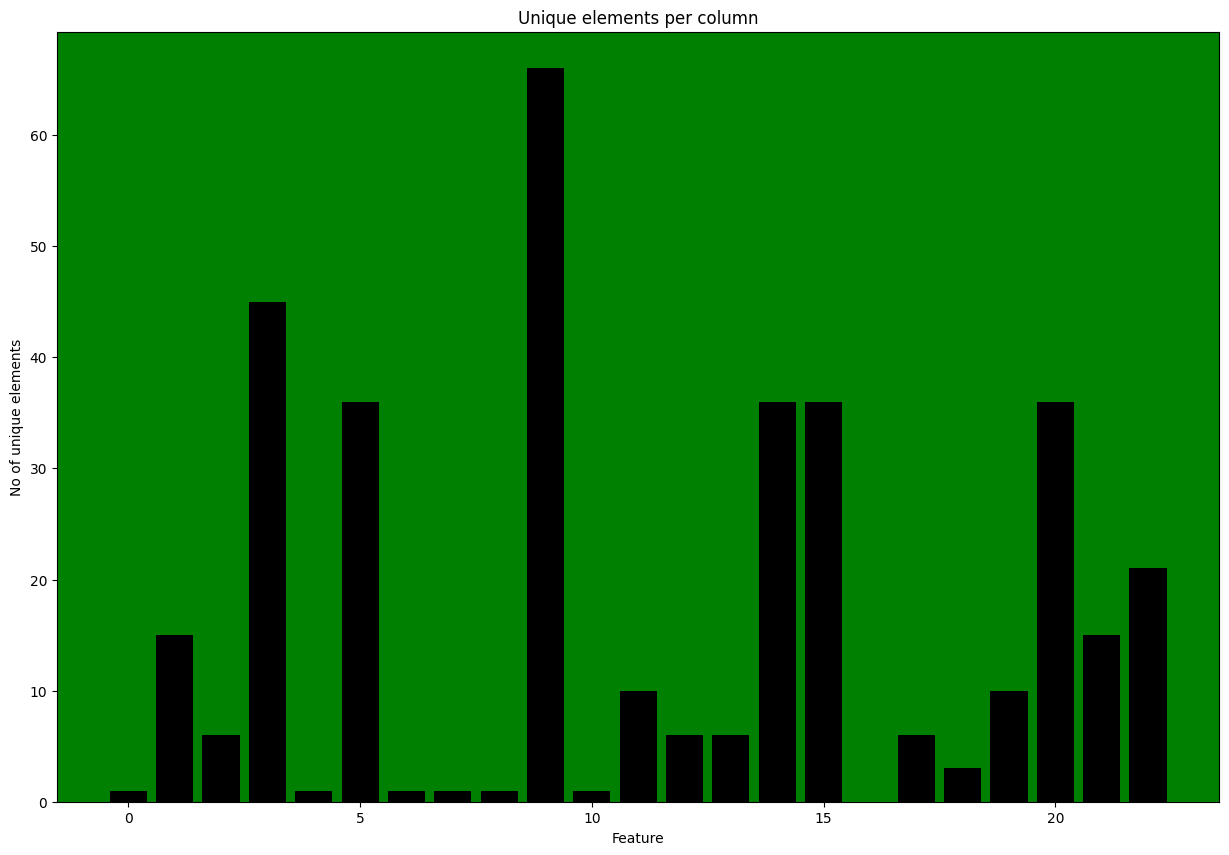

In [430]:
count_var=[]

for col in mushroom.columns:
    count_var.append(mushroom[col].unique().sum()) # Series 접근 column으로 접근하므고 Series와 똑같음
    # dataframe duplicated, duplicates -> 중복제거

size=np.arange(len(count_var))

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1,facecolor='g')
ax.bar(size,count_var,color='k')
ax.set(title='Unique elements per column',
       ylabel='No of unique elements',
       xlabel='Feature')

<Axes: >

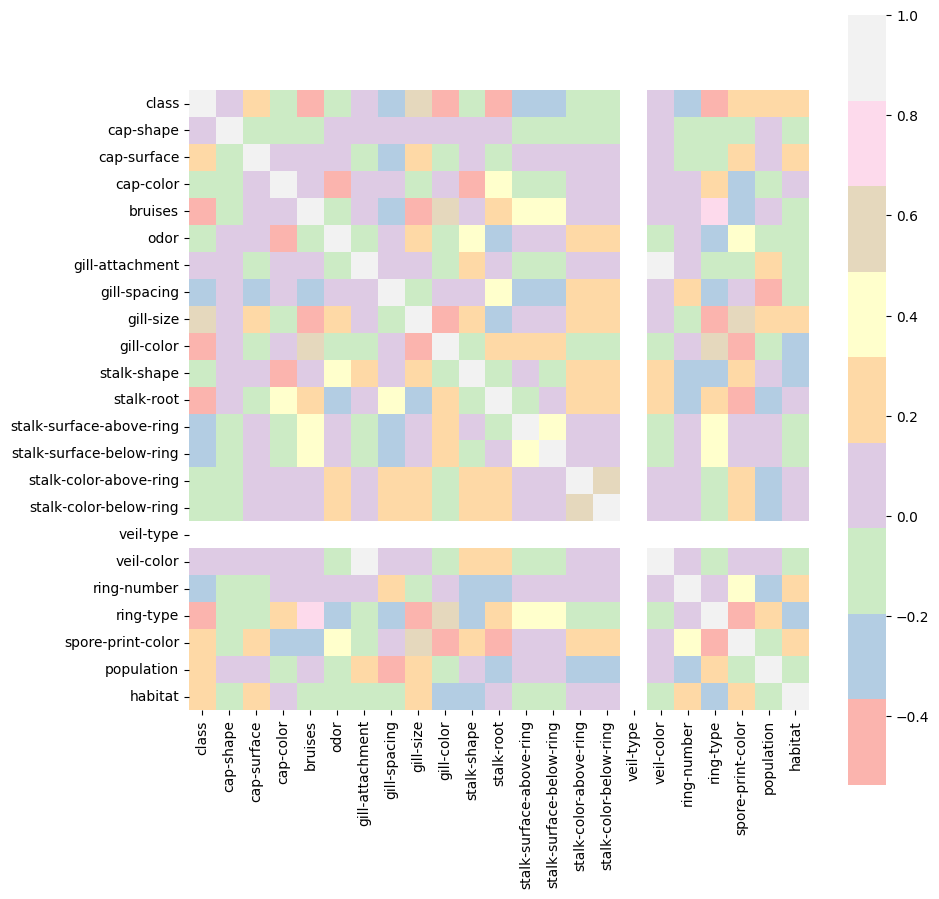

In [456]:
plt.figure(figsize=(10,10))
sns.heatmap(mushroom.corr(), cmap='Pastel1',square=True)

In [436]:
target=mushroom['class']
train=mushroom.drop('class',axis=1)

Text(0.5, 1.0, 'Class distribution')

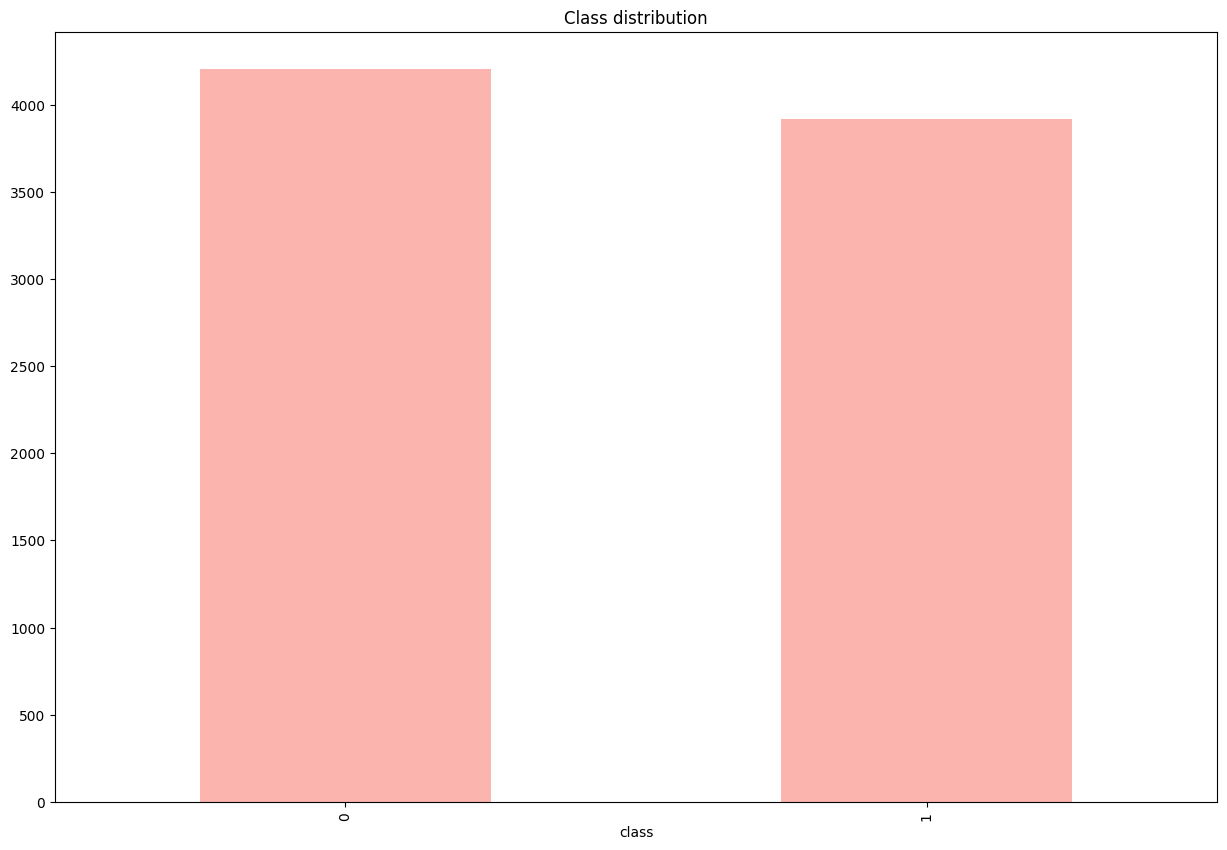

In [457]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1,facecolor='white')
pd.value_counts(target).plot(kind='bar',cmap='Pastel1')
plt.title('Class distribution')

In [458]:
target=mushroom['class']
train=mushroom.drop('class',axis=1)

Text(0.5, 1.0, 'Class distribution')

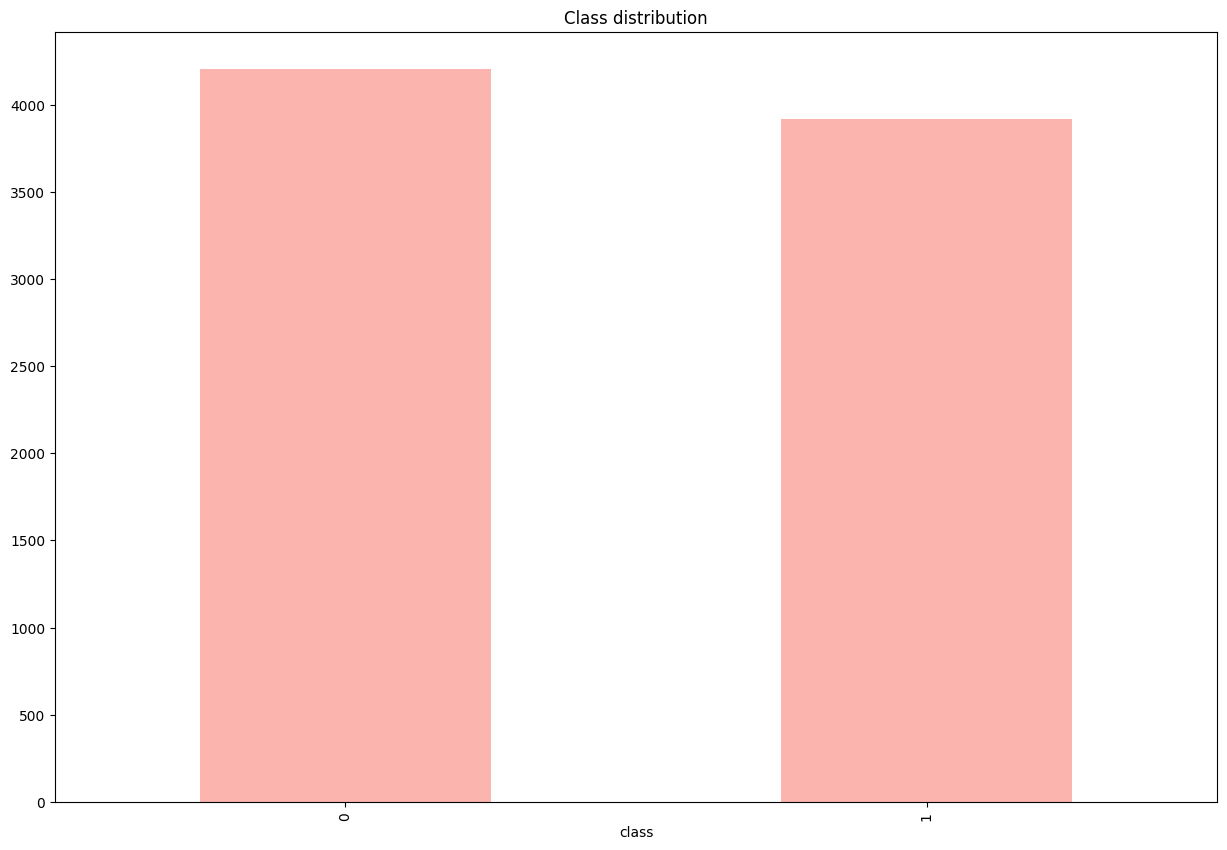

In [459]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1,facecolor='white')
pd.value_counts(target).plot(kind='bar',cmap='Pastel1')
plt.title('Class distribution')

In [460]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(train, target)
clf.score(train, target)

0.9519940915805022